**Objective of the Task**: Demonstrate the ability to work with time series data.

Attached is a dataset containing sell-out information (sales from stores to end customers).

In this specific case, the data represents sales of "Drink 0.5L" and "Drink 1.0L" within the XX chain in Moscow for the period 2020-2021 (not full years). The dataset aggregates sales data across all XX chain stores in Moscow.

<br>The table includes the following columns:

- ChainName – chain name
- City – city
- Year_445 – record year
- Month_445 – record month
- Week_445 – record week
- Producer – producer
- Brand – brand
- Flavor – flavor
- PackageSize – package size
- Item – quantity of items sold
- Price – weighted average selling price
- DoD – discount depth in percentage
- Regular_Price – regular price
- Promo_Price – promotional price
<br>**Task**:
Build a model (or models) capable of forecasting sales for two weeks ahead for each product represented in the dataset by PackageSize (separately for "Drink 0.5L" and "Drink 1.0L").

**Period**:
2020-2021 (not full years).
<br>**Data**:
Sales data for "Drink 0.5L" and "Drink 1.0L" in the XX chain over the specified period.

The analysis will be performed step-by-step based on the following stages:

1. Data extraction
2. Data preparation
3. Time series construction
4. Data preparation for model training and forecasting
5. Training forecast for 2 weeks for PackageSize 0.5
6. Training forecast for 2 weeks for PackageSize 1.0
7. Main forecast for 2 weeks for PackageSize 0.5
8. Main forecast for 2 weeks for PackageSize 1.0
9. Visualization of forecast results for PackageSize 0.5 and PackageSize 1.0.


In [88]:
# Importing necessary libraries
import pandas as pd  # For data manipulation
import matplotlib.pyplot as plt  # For data visualization
import numpy as np  # For numerical computations
import re  # For text string manipulation using patterns

from statsmodels.graphics.tsaplots import plot_acf  # For plotting autocorrelation
from sklearn.metrics import mean_absolute_error, mean_squared_error  # For evaluating model accuracy

import warnings
warnings.filterwarnings("ignore")  # Disabling all warnings

# import matplotlib.dates as mdates  # Uncomment if working with date formatting
# from sklearn.model_selection import train_test_split  # Uncomment if splitting data is needed
# import seaborn as sns  # Uncomment if advanced visualizations are needed

## 1. Data extraction

In [89]:
# Extracting data from the table
# Assuming the data file is in xlsx format and stored in the current directory

Dataset = pd.read_excel(r'/kaggle/input/DataTable.xlsx')

In [90]:
Dataset.head(3)

,ChainName,City,Year_445,Month_445,Week_445,Producer,Brand,Flavor,PackageSize,Item,Price,DoD,Promo_Price,Regular_Price
0,ХХ,Москва,2020,9,36,BevCom,Privat label,no,1.0,"3 347,00",1310.10,NaN,NaN,1310.10
1,ХХ,Москва,2020,9,37,BevCom,Privat label,no,1.0,"6 455,00",1191.45,NaN,1049.1,1194.90
2,ХХ,Москва,2020,9,38,BevCom,Privat label,no,1.0,"28 960,00",1048.95,0.138,1048.8,1215.45


In [7]:
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ChainName      115 non-null    object 
 1   City           115 non-null    object 
 2   Year_445       115 non-null    int64  
 3   Month_445      115 non-null    object 
 4   Week_445       115 non-null    int64  
 5   Producer       115 non-null    object 
 6   Brand          115 non-null    object 
 7   Flavor         115 non-null    object 
 8   PackageSize    115 non-null    float64
 9   Item           115 non-null    object 
 10  Price          115 non-null    float64
 11  DoD            86 non-null     object 
 12  Promo_Price    105 non-null    float64
 13  Regular_Price  105 non-null    float64
dtypes: float64(4), int64(2), object(8)
memory usage: 12.7+ KB


## 2. Data preparation

After a preliminary review of the data, the following issues were identified:

Mismatched data types for the following columns: **Month_445, Item, DoD.**
<br>Missing values in the following columns: **DoD, Promo_Price, Regular_Price.**

Let's identify problematic values in these columns:

In [8]:
# нахождение строковых значений
def find_str_in_object(dataset, columns):
    for column in columns:
        
        # Проверяем, является ли столбец типом 'object'
        if dataset[column].dtype == 'object':
            
            # Преобразование в числовые значения с заменой некорректных на NaN
            numeric_values = pd.to_numeric(dataset[column], errors='coerce')
            
            # Индексы строк с NaN
            invalid_values = numeric_values[numeric_values.isna()].index

            if len(invalid_values) > 0:
                print(f'Найдены следующие строковые значения в колонке {column}:')               
                problematic_rows = dataset.loc[invalid_values, column] # Выводим только проблемные строки, исключая NaN

                # Фильтруем строки, которые не являются NaN и показываем их
                problematic_values = problematic_rows.dropna().unique()
                print(problematic_values)

In [9]:
# Передаем в функцию датасет и колонки
find_str_in_object(Dataset, Dataset.columns)

Найдены следующие строковые значения в колонке ChainName:
['ХХ']
Найдены следующие строковые значения в колонке City:
['Москва']
Найдены следующие строковые значения в колонке Month_445:
['1О']
Найдены следующие строковые значения в колонке Producer:
['BevCom']
Найдены следующие строковые значения в колонке Brand:
['Privat label']
Найдены следующие строковые значения в колонке Flavor:
['no' 'nо']
Найдены следующие строковые значения в колонке Item:
['3\xa0347,00' '6\xa0455,00' '28\xa0960,00' '32\xa0082,00' '25\xa0823,00'
 '4\xa0816,00' '2\xa0363,00' '5\xa0840,00' '23\xa0345,00' '5\xa0812,00'
 '30\xa0880,00' '6\xa0283,00' '31\xa0774,00' '7\xa0807,00' '29\xa0449,00'
 '10\xa0648,00' '12\xa0356,00' '8\xa0351,00' '20\xa0381,00' '9\xa0802,00'
 '22\xa0075,00' '12\xa0548,00' '11\xa0101,00' '13\xa0754,00' '9\xa0403,00'
 '11\xa0077,00' '12\xa0137,00' '8\xa0119,00' '11\xa0564,00' '8\xa0778,00'
 '24\xa0340,00' '11\xa0203,00' '23\xa0207,00' '11\xa0265,00'
 '13\xa0409,00' '10\xa0183,00' '12\xa0395,0

Выявлены следующие проблемные значения:

* Неверный формат данных в колонке **Month_445**: 1О, где O - строка, необходима замена на цифру 0.
* Дублирование строковых значения в колонке **Flavor**: ['no' 'nо'] — нужно привести к единому виду.
* Неверный формат в колонке **Item**: строки содержат запятые и пробелы (например, '3\xa0347,00'). Нужно привести к числовому типу, удалив лишние символы.
* Неверный формат в колонке **DoD**: строки содержат пробелы и символы ('37.00%' и ' 2 9, 2 % '). Необходимо привести к числовому формату для дальнейшего анализа.

Начнем обработку данных по упомянутым столбцам (названия столбца: действия по обработке)

##### Flavor: коррекция строковых значений

In [10]:
# Определяем количество уникальных значений 
flavor_counts = Dataset['Flavor'].value_counts()
print(flavor_counts)

Flavor
no    114
nо      1
Name: count, dtype: int64


In [11]:
# Заменяем значения 'nо' (с ошибкой в написании) на корретный no
Dataset['Flavor'] = Dataset['Flavor'].str.replace('nо', 'no')
flavor_counts = Dataset['Flavor'].value_counts()

#Проверяем результат замены и дата тип столбца
print(flavor_counts)

Flavor
no    115
Name: count, dtype: int64


##### Item: очистка и форматирование строковых значений

In [12]:
# Очищаем данные от лишних символов и преобразуем колонку в числовой тип
if Dataset['Item'].dtype == 'object':
    Dataset['Item'] = Dataset['Item'].str.replace(r'\s+', '', regex=True).str.replace(',', '.')
    
    Dataset['Item'] = pd.to_numeric(Dataset['Item'])
# Проверяем что тип столбца = float64
Dataset['Item'].dtype

dtype('float64')

##### DoD: Диагностика и очистка данных

In [13]:
# Повторно просматриваем проблемные значения
print(Dataset['DoD'].unique())

[nan 0.138 0.152 0.204 0.22 0.229 0.225 0.3 0.271 0.294 0.246 0.347 0.299
 '37.00%' 0.255 0.334 0.312 0.355 0.33 0.31 0.265 0.361 0.201 0.36 0.314
 0.353 0.309 0.368 0.302 0.356 0.32 0.191 0.214 0.234 0.232 0.381 0.168
 0.295 0.167 0.183 0.181 0.261 0.175 0.266 0.211 0.213 0.205 0.223 0.19
 0.218 0.241 0.182 0.185 0.224 0.197 0.203 0.306 0.256 0.248 0.216 0.276
 0.305 0.215 0.281 0.315 0.326 0.343 0.292 0.273 0.226 0.195 0.154 0.537
 0.311 0.296 0.357 0.258 ' 2 9, 2 %  ']


In [14]:
# Очищаем и преобразуем строковые проценты в корретный числовой формат
def clean_percentage(dataset, column_name):

    for index, value in enumerate(dataset[column_name]): #добавляем индекс к каждому значению, теперь индекс значения в цикле и можно обработать значение(я)

        if isinstance(value, str): 
            # убираем # и пробелы(spaces), заменяем , на .
            value = value.replace('%', '') 
            value = value.replace(' ', '')   
            value = value.replace(',', '.')    

            # Пробуем преобразовать строку в float
            try: dataset.at[index, column_name] = float(value) / 100
            except ValueError: dataset.at[index, column_name] = float('nan')  # Или оставляем значение как NaN

# Применяем функцию к пробленому столбцу DoD для очистки значений
clean_percentage(Dataset, 'DoD')

In [15]:
# Преобразовываем колонку в числовой формат
Dataset['DoD'] = pd.to_numeric(Dataset['DoD'])

# Проверяем что тип столбца = float64 и повторно анализируем значения
print(Dataset['DoD'].info())
print()
print(Dataset['DoD'].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 115 entries, 0 to 114
Series name: DoD
Non-Null Count  Dtype  
--------------  -----  
86 non-null     float64
dtypes: float64(1)
memory usage: 1.0 KB
None

[  nan 0.138 0.152 0.204 0.22  0.229 0.225 0.3   0.271 0.294 0.246 0.347
 0.299 0.37  0.255 0.334 0.312 0.355 0.33  0.31  0.265 0.361 0.201 0.36
 0.314 0.353 0.309 0.368 0.302 0.356 0.32  0.191 0.214 0.234 0.232 0.381
 0.168 0.295 0.167 0.183 0.181 0.261 0.175 0.266 0.211 0.213 0.205 0.223
 0.19  0.218 0.241 0.182 0.185 0.224 0.197 0.203 0.306 0.256 0.248 0.216
 0.276 0.305 0.215 0.281 0.315 0.326 0.343 0.292 0.273 0.226 0.195 0.154
 0.537 0.311 0.296 0.357 0.258]


После просмотра данных были замечены отрицательные значения типа '-0.20918894', необходимо будет проверить все числовые данные на наличие выброс и обработать в случае наличия выбросов.

##### Month_445: Очистка и преобразование строковых значений

In [16]:
def month_validation(dataset, column_name):
    # Итерация по значениям столбца
    for index, value in enumerate(dataset[column_name]):
        if isinstance(value, str):  # Проверяем, является ли значение строкой, если да то идем дальше:
            dataset.at[index, column_name] = re.sub(r'1[oOоО]', '10', value) #учитываем регистр строкового значения #Замена символов '1' с кириллическими 'о' на '10' в строках столбца
    dataset[column_name] = pd.to_numeric(dataset[column_name], errors='coerce') #по завершению цикла > # Преобразуем столбец в числовой формат

    # Проверка наличия NaN после преобразования, ожидаем отсутствие Nan
    print("Есть ли NaN после преобразования?", dataset[column_name].isna().sum())

In [17]:
# передаем датасет и проблемную колонку в функцию
month_validation(Dataset, 'Month_445')

Есть ли NaN после преобразования? 0


In [18]:
# Финально проверяем столбцы
# Передаем датасет со всеми колонками в функцию для проверки на наличие строковых значений в столбцах
find_str_in_object(Dataset, Dataset.columns)

Найдены следующие строковые значения в колонке ChainName:
['ХХ']
Найдены следующие строковые значения в колонке City:
['Москва']
Найдены следующие строковые значения в колонке Producer:
['BevCom']
Найдены следующие строковые значения в колонке Brand:
['Privat label']
Найдены следующие строковые значения в колонке Flavor:
['no']


In [19]:

# Смотрим кол-во пропущенных значения в текущем датасете
Dataset.isna().sum()

ChainName         0
City              0
Year_445          0
Month_445         0
Week_445          0
Producer          0
Brand             0
Flavor            0
PackageSize       0
Item              0
Price             0
DoD              29
Promo_Price      10
Regular_Price    10
dtype: int64

In [20]:
#Небольшой ручной анализ пропусков в зависимости от других столбцов

#Dataset.groupby(['Week_445'])['Promo_Price'].apply(lambda x: x.isnull().mean())
#Month_445 DoD (4,5)
#Month_445 Promo_Price (5)
#В пропусках не было выявлено завивимости от других переменных, наибольшая частота повтора пропусков для DoD встречалась в 4,5 и месяцах 21 года, и для Promo_Price в 5 месяце 21года.
#Зависимость по годам отсутствует

Заполнение пропусков для столбцов DoD, Promo_Price, и Regular_Price будет выполнено с помощью линейной регрессией (модель **IterativeImputer**).

Этот метод выбран, так как эти данные скорее всего имеют зависимость(линейную) от других переменных в текущем наборе данных

In [21]:
# Смотрим std до заполнения NaN для последующего сравнения с результата после заполнения
Dataset[['DoD', 'Promo_Price','Regular_Price']].std()

DoD                0.068253
Promo_Price      147.305149
Regular_Price    264.467822
dtype: float64

In [22]:
##### Заполняем пропуски NaN в числовых столбцах: DoD, Promo_Price и Regular_Price.

# Заполнение пропусков с помощью модели линейной регрессии с использованием IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [23]:

def fill_missing_values_with_regression(df, columns_to_impute, estimator=LinearRegression(), max_iter=10, random_state=42):

    
    # Проверяем, что столбцы для обработки являются числовыми
    for column in columns_to_impute:
        if not pd.api.types.is_numeric_dtype(df[column]):
            raise ValueError(f"Столбец {column} должен быть числовым для использования регрессии.")
    
    # Создаем и обучаем модель IterativeImputer
    imputer = IterativeImputer(estimator=estimator, max_iter=max_iter, random_state=random_state)
    # Преобразуем указанные столбцы и обучаем модель
    imputed_data = imputer.fit_transform(df[columns_to_impute])
    
    # Создаем DataFrame с предсказанными значениями
    imputed_df = pd.DataFrame(imputed_data, columns=columns_to_impute)
    # Заменяем пропущенные значения в исходном DataFrame
    df[columns_to_impute] = imputed_df

    return df


    """
    Функция для заполнения пропущенных значений в DataFrame с использованием линейной регрессии.

    Параметры:
    - df: DataFrame, данные для обработки.
    - columns_to_impute: список строк, содержащий имена столбцов для заполнения пропусков.
    - estimator: модель для заполнения пропусков - LinearRegression).
    - max_iter: максимальное количество итераций для IterativeImputer.
    - random_state: для воспроизводимости результатов.

    Возвращает:
    - DataFrame с заполненными пропущенными значениями.
    """

In [24]:
#Передаем датасет с колонками где необходимо заполнить пропуски NaN
Dataset = fill_missing_values_with_regression(Dataset, ['DoD', 'Promo_Price', 'Regular_Price'])

In [25]:
# Проверяем std(сркв. отклон.) после заполнения пропусков -  для понимания насколько приемлимы изменения после заполнения пустых значений
print(Dataset[['DoD', 'Promo_Price','Regular_Price']].std())
print()
# Проверка наличия отсутствующих значений после импутации
print(Dataset.isna().sum())

DoD                0.076142
Promo_Price      142.350693
Regular_Price    255.439071
dtype: float64

ChainName        0
City             0
Year_445         0
Month_445        0
Week_445         0
Producer         0
Brand            0
Flavor           0
PackageSize      0
Item             0
Price            0
DoD              0
Promo_Price      0
Regular_Price    0
dtype: int64


Получили незначительные увеличение std для **DoD с 0.068 на 0.076** <br>
Получили небольшое уменьшение std для **Promo_Price 147.31** до **142.35 и Regular_Price**  264.47 до 255.44 <br>
**Вывод**: изменения приемлимы.

Прежде чем перейти к прогнозу данных проверим наличие пробелов в названиях столбцов для полной согласованности в названиях.

In [26]:
# Проверяем, есть ли пробелы в именах столбцов
def check_strip_in_column_names(dataframe):
    if any(' ' in column for column in dataframe.columns):
        # Удаляем пробелы по краям
        dataframe.columns = dataframe.columns.str.strip()
        print("Названия столбцов после удаления пробелов по краям:", dataframe.columns.tolist())

    else: print("Столбцы не имеют пробелов по краям в названиях")
    return dataframe
Dataset = (lambda df: check_strip_in_column_names(df))(Dataset)

Столбцы не имеют пробелов по краям в названиях


## 3. Построение временных рядов

В рамках работы с временными рядами работа будет строится следующим образом:
1. Преборазование данных в формат временного ряда
2. Визуализация трендов и сезонных колебаний
3. Агрегация данных
4. Проверка на стационарность

In [27]:
# Построение графиков для визуализации трендов и сезонных колебаний.
# Проверка на стационарность: Важно проверить, не изменяются ли свойства ряда (например, среднее или дисперсия) со временем. Если ряд нестационарен, можно применить преобразования, такие как разности.

Для преобразования данных импортируем модуль **timedelta**

In [28]:
# Импортируем модуль 
from datetime import timedelta #для добавления/вычитания дней, недель и.т.д

In [29]:
def get_start_of_week(row):
    # Получаем первую дату месяца
    month_start = pd.to_datetime(f"{row['Year_445']}-{row['Month_445']:02d}-01")
    
    # Находим первый понедельник после начала месяца
    first_monday = month_start + pd.offsets.Week(weekday=0) if month_start.weekday() != 0 else month_start
    
    # Фильтрм строки по месяцу
    month_data = Dataset[Dataset['Month_445'] == row['Month_445']]
    
    # Проверка, что для месяца есть данные
    if not month_data.empty:
        # Если данные есть, находим минимальное значение недели в этом месяце
        weeks_diff = int(row['Week_445'] - month_data['Week_445'].min())
    else:
        # Если данных нет, можно задать дефолтное значение для weeks_diff
        weeks_diff = 0
    
    # Находим точную дату начала недели
    start_of_week = first_monday + timedelta(weeks=weeks_diff)
    # Проверяем, что дата не выходит за пределы месяца
    if start_of_week.month != row['Month_445']:
        # Получаем количество дней в месяце
        days_in_month = pd.Timestamp(f"{row['Year_445']}-{row['Month_445']:02d}").days_in_month
        # Корректируем дату на последний день месяца
        start_of_week = pd.to_datetime(f"{row['Year_445']}-{row['Month_445']:02d}-{days_in_month}")
    return start_of_week

# Создаем новую колонку Date для хранения даты и записываем в нее данные применяя функцию для каждой строки
Dataset['Date'] = Dataset.apply(get_start_of_week, axis=1)


In [30]:
# Проверяем полноту и корректность заполннего временного ряда
# Группируем по году и месяцу, тем самым сопоставля результат с исходными данными для проверки заполнения Date
print(Dataset['Date'].isna().sum())
print(Dataset.groupby(['Year_445', 'Month_445'])['Date'].min())

0
Year_445  Month_445
2020      9           2020-09-07
          10          2020-10-05
          11          2020-11-02
          12          2020-12-07
2021      1           2021-01-04
          2           2021-02-01
          3           2021-03-01
          4           2021-04-05
          5           2021-05-03
          6           2021-06-07
          7           2021-07-05
          8           2021-08-02
          9           2021-09-06
          10          2021-10-04
          11          2021-11-01
Name: Date, dtype: datetime64[ns]


Визуализация трендов и сезонных колебаний

Разделим данные на отдельные выборки для товаров с разными объемами PackageSize (0.5 и 1.0)

In [31]:
# Фильтруем данные на основе объема 1.0 и 0.5
data_item_1_0 = Dataset[Dataset['PackageSize'] == 1.0].copy()
data_item_05 = Dataset[Dataset['PackageSize'] == 0.5].copy()

# Проверяем уникальные значения для каждой из групп
print('PackageSize for 1.0 unique value:', data_item_1_0['PackageSize'].unique().sum())
print('PackageSize for 0.5 unique value:', data_item_05['PackageSize'].unique().sum())

PackageSize for 1.0 unique value: 1.0
PackageSize for 0.5 unique value: 0.5


Обработаем все числовые столбцы от возможных выбросов, т.к. ранее мы выявили нехарактерное для DoD отрицательное значение или близкое к 0 для Regular Price (15.000000)
<br> Пропуски будут обработваны интерполяцией

In [32]:
#Функция принимает датафрейм, названия датафрейма для сопоставления
def handle_outliers(df, df_name, columns):
    # скопируем чтобы не изменять оригинал
    df_out = df.copy()
    
    for col in columns:
        if col in df_out.columns:
            Q1 = df_out[col].quantile(0.25)
            Q3 = df_out[col].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Выбираем значения, которые являются выбросами
            outliers = df_out[(df_out[col] < lower_bound) | (df_out[col] > upper_bound)][col]
            
            # Выводим сообщение если выброс был найден (не пустой) и значения самого выброса
            if not outliers.empty:
                print(f"Датафрейм: {df_name}, Колонка: {col}, Значения выброса: {outliers.values}")
            
            # Заменяем выбросы на NaN
            df_out.loc[(df_out[col] < lower_bound) | (df_out[col] > upper_bound), col] = None
            # Здесь же заменяем пустые значения интерполяцией
            df_out[col] = df_out[col].interpolate(method='linear')
        else:
            print(f"Колонка '{col}' не найдена в датафрейме {df_name}")
    
    return df_out

# Список колонок которые необходимо обработать от выбросов
specific_columns = ['Item', 'Price', 'DoD', 'Promo_Price', 'Regular_Price']


In [33]:
#Передаем в функцию ранее отсортированные выборки(колонки) Напитков 0.5 и 1.0 для очистки от выбросов
data_item_05_cleaned = handle_outliers(data_item_05, 'data_item_05', specific_columns)
data_item_1_0_cleaned = handle_outliers(data_item_1_0, 'data_item_0_1', specific_columns)

Датафрейм: data_item_05, Колонка: Item, Значения выброса: [2406.]
Датафрейм: data_item_05, Колонка: Price, Значения выброса: [1294.2  1296.75]
Датафрейм: data_item_05, Колонка: DoD, Значения выброса: [0.537]
Датафрейм: data_item_05, Колонка: Regular_Price, Значения выброса: [823.05]
Датафрейм: data_item_0_1, Колонка: DoD, Значения выброса: [-0.20918894]
Датафрейм: data_item_0_1, Колонка: Promo_Price, Значения выброса: [1351.05  847.95 1339.95 1339.2  1331.4  1339.35 1337.55]
Датафрейм: data_item_0_1, Колонка: Regular_Price, Значения выброса: [15.]


In [34]:
#Отдельно проверяем min значения для Regular_Price, ожидается отсутствие 15.000000
data_item_1_0_cleaned['Regular_Price'].describe()

count      61.000000
mean     1506.129674
std       134.808269
min      1140.300000
25%      1414.540380
50%      1532.250000
75%      1628.400000
max      1709.700000
Name: Regular_Price, dtype: float64

Аггрегируем данные по месяцам для визуализации продаж

In [35]:
# Агрегируем данные по неделям для первой выборки (data_item_1_0_cleaned)
aggregated_data_item_1_0 = data_item_1_0_cleaned.groupby('Date').agg({
    'Item': 'sum',  # Сумма количества проданных товаров
    'Price': 'mean',  # Средняя цена
    'DoD': 'mean',  # Средняя глубина скидки
    'Promo_Price': 'mean',  # Средняя промо-цена
    'Regular_Price': 'mean'  # Средняя регулярная цена
}).reset_index()

# Агрегируем данные по неделям для первой выборки (data_item_1_0_cleaned)
aggregated_data_item_0_5 = data_item_05_cleaned.groupby('Date').agg({
    'Item': 'sum',  # Сумма количества проданных товаров
    'Price': 'mean',  # Средняя цена
    'DoD': 'mean',  # Средняя глубина скидки
    'Promo_Price': 'mean',  # Средняя промо-цена
    'Regular_Price': 'mean'  # Средняя регулярная цена
}).reset_index()

print(aggregated_data_item_1_0.head())
print(aggregated_data_item_0_5.head())

        Date     Item    Price       DoD  Promo_Price  Regular_Price
0 2020-09-07   3347.0  1310.10  0.261578  1027.096269        1310.10
1 2020-09-14   6455.0  1191.45  0.214881  1049.100000        1194.90
2 2020-09-21  28960.0  1048.95  0.138000  1048.800000        1215.45
3 2020-09-28  32082.0  1048.95  0.152000  1048.800000        1140.30
4 2020-10-05  25823.0  1048.95  0.204000  1048.800000        1318.20
        Date     Item   Price       DoD  Promo_Price  Regular_Price
0 2020-10-26   5840.0   822.9  0.215802       764.10            NaN
1 2020-11-02   5812.0  1038.9  0.300000       869.55    1040.400000
2 2020-11-09   6283.0  1014.0  0.294000       828.15    1035.150000
3 2020-11-16   7807.0   823.5  0.271256       823.50    1072.301279
4 2020-11-23  10648.0   823.5  0.299000       823.35    1157.850000


Построим тепловую карту чтобы посмотреть частоту продаж в зависимости от цены на товар

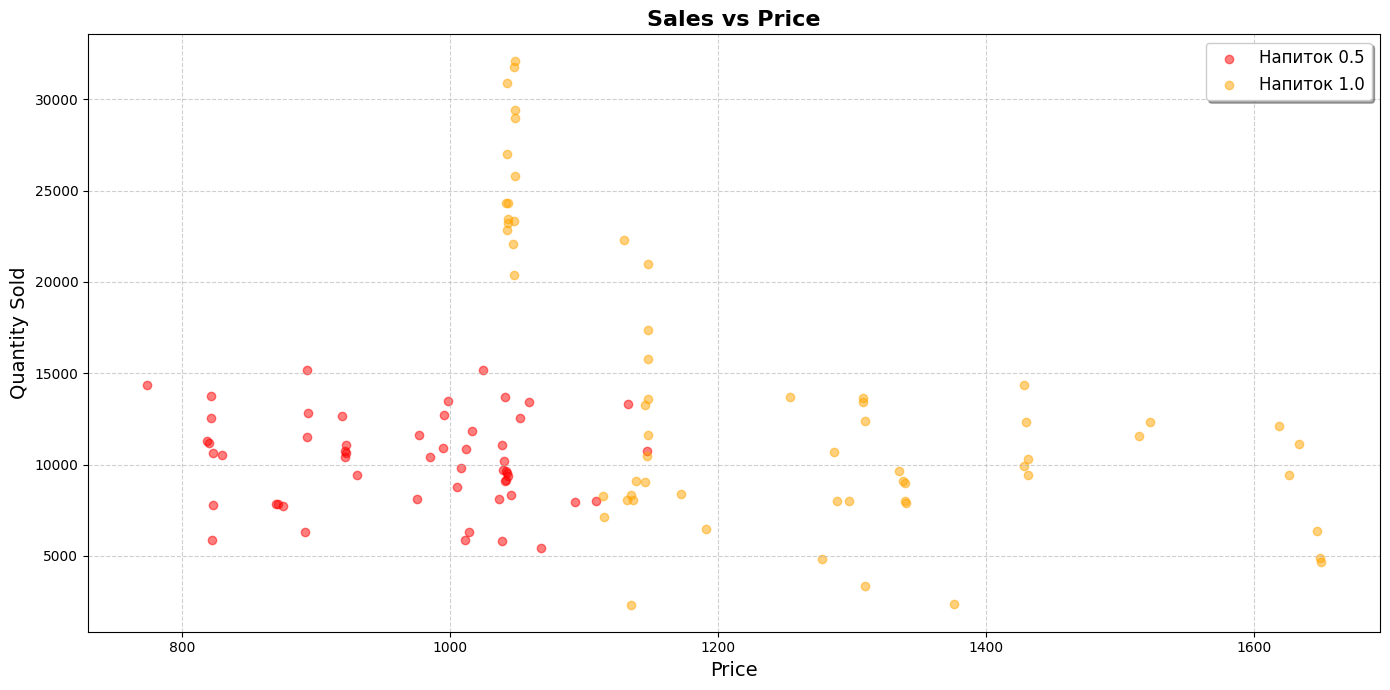

In [36]:
plt.figure(figsize=(14, 7))

# График для data_item_05_cleaned
plt.scatter(data_item_05_cleaned['Price'], 
            data_item_05_cleaned['Item'], 
            color='red', alpha=0.5, label='Напиток 0.5')

# График для data_item_1_0_cleaned
plt.scatter(data_item_1_0_cleaned['Price'], 
            data_item_1_0_cleaned['Item'], 
            color='orange', alpha=0.5, label='Напиток 1.0')

plt.title('Sales vs Price', fontsize=16, fontweight='bold')
plt.xlabel('Price', fontsize=14)
plt.ylabel('Quantity Sold', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, frameon=True, shadow=True, fancybox=True)
plt.tight_layout()
plt.show()


**Напиток 0.5** (красные точки): <br>Продажи в среднем около 10.000 не сильно зависят от изменения цены, которая варьируется от 800 до 1200. <br>Большая часть продаж сосредоточена в диапазоне от 900 до 1100.

**Напиток 1.0** (оранжевые точки) <br>Продажи показывают более широкий разброс по цене — от 1000 до 1600. 
Наблюдается некоторая зависимость от цены, так как максимальные объемы продаж (до 30,000) происходят при цене около . <br>Вывод: Напиток 1.0 имеет более высокие объемы продаж и больший диапазон цен, тогда как напиток 0.5 имеет более стабильные продажи, но с меньшим максимальным объемом.

Создадим линеный график для демонстрации тренда продаж двух товаров (Item 0.5 и Item 1.0) по месяцам за 2021 год (полный год)

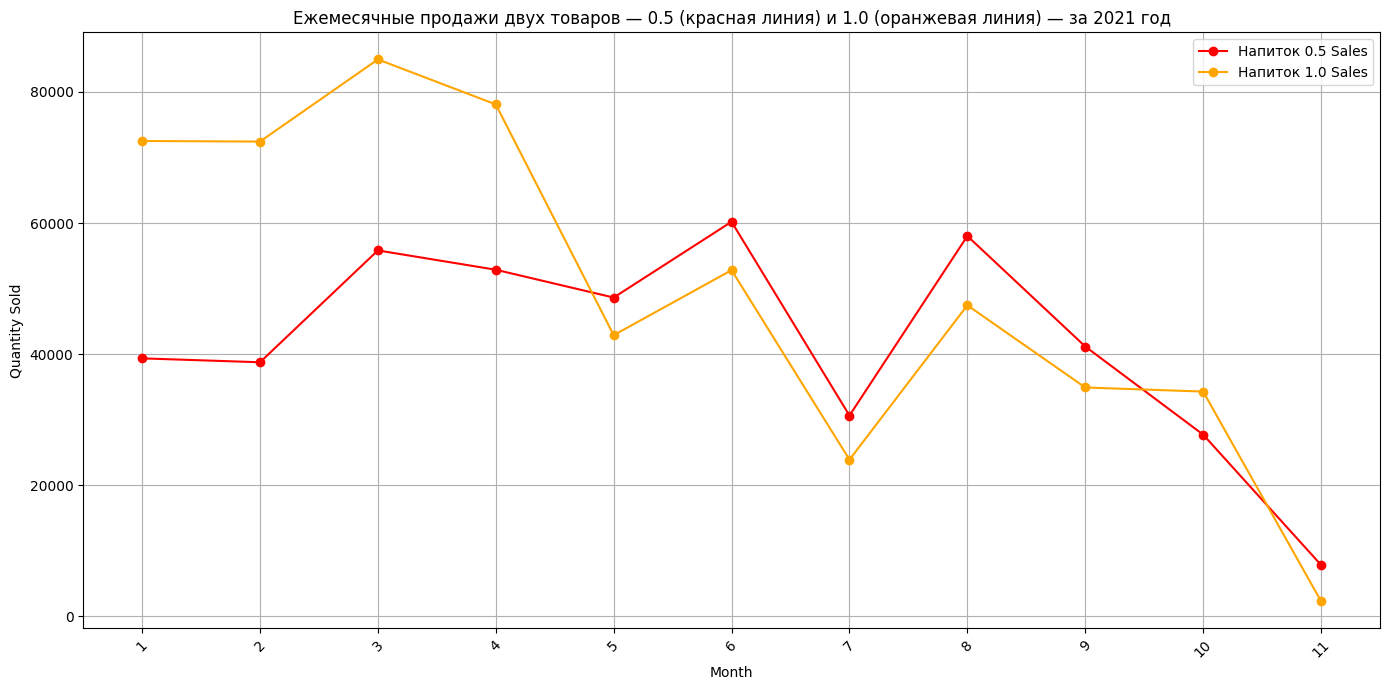

In [37]:
# Фильтруем данные за 2021 год
data_item_05_2021 = data_item_05_cleaned[data_item_05_cleaned['Date'].dt.year == 2021]
data_item_1_0_2021 = data_item_1_0_cleaned[data_item_1_0_cleaned['Date'].dt.year == 2021]

# Аггрегируем данные по месяцам для 2021 года
aggregated_by_month_data_05 = data_item_05_2021.groupby('Month_445').agg({'Item': 'sum'}).reset_index()
aggregatedby_month_data_0_1 = data_item_1_0_2021.groupby('Month_445').agg({'Item': 'sum'}).reset_index()

# Построение графиков
plt.figure(figsize=(14, 7))

# График для первого DataFrame (Item 0.5 Sales)
plt.plot(aggregated_by_month_data_05['Month_445'].astype(str), aggregated_by_month_data_05['Item'], marker='o', color='red', label='Напиток 0.5 Sales')

# График для второго DataFrame (Item 1.0 Sales)
plt.plot(aggregatedby_month_data_0_1['Month_445'].astype(str), aggregatedby_month_data_0_1['Item'], marker='o', color='orange', label='Напиток 1.0 Sales')

# Оформление графика
plt.title('Ежемесячные продажи двух товаров — 0.5 (красная линия) и 1.0 (оранжевая линия) — за 2021 год')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


По результатам визуализации тренда продаж по месяцам можно сделать следующие утрвеждения:
* Напиток 1.0 - сезонные колебания спроса, с пиковыми продажами в начале года и спадом в середине, что указывает на возможные зависимости от времени года.
* Напиток 0.5 - стабильный уровень продаж, равномерный спрос

**Вывод:** Для Item 1.0 можно увеличить 'маркетинговые' усилия в периоды пикового спроса, а для Item 0.5 — поддерживать уровень продаж

График скользящего среднего

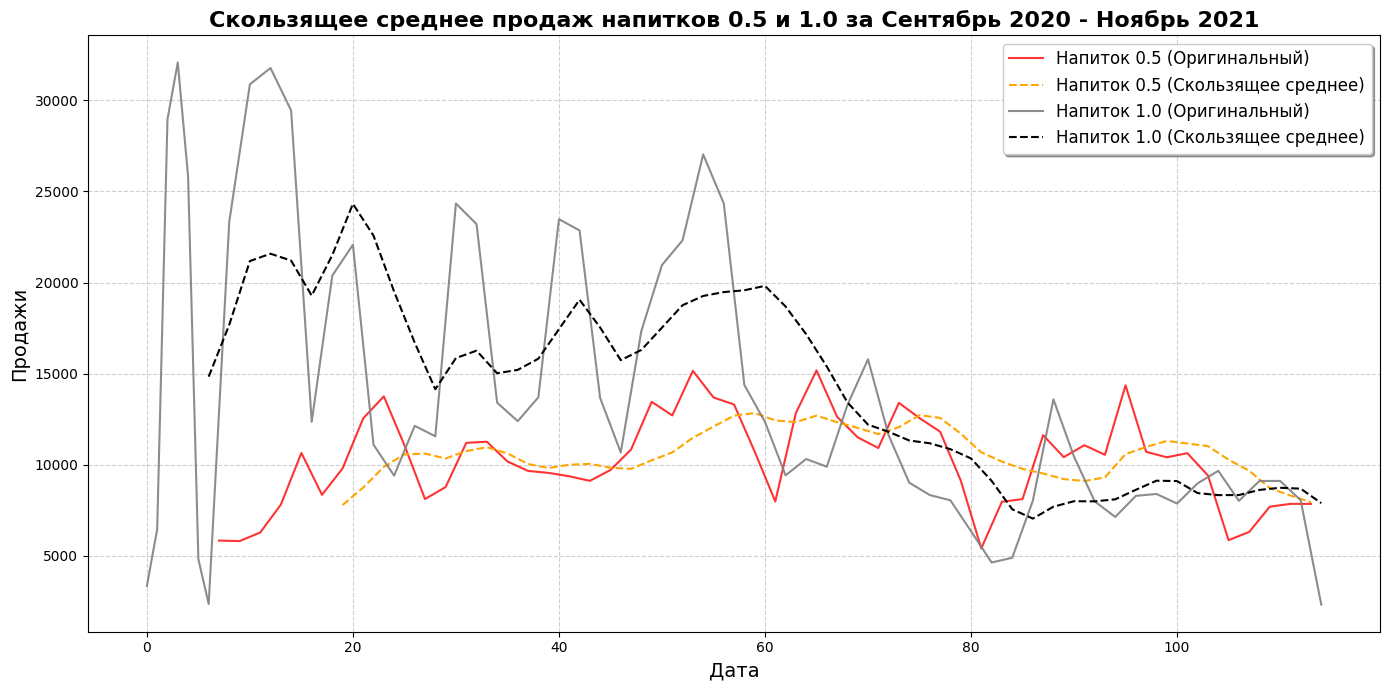

In [38]:
# Параметры скользящего среднего
window_size = 7  # Скользящее среднее за неделю

# Вычисление скользящего среднего
data_item_05_rolling = data_item_05_cleaned['Item'].rolling(window=window_size).mean()
data_item_1_0_rolling = data_item_1_0_cleaned['Item'].rolling(window=window_size).mean()

plt.figure(figsize=(14, 7))

# Напиток 0.5
plt.plot(data_item_05_cleaned.index, data_item_05_cleaned['Item'], color='red', alpha=0.8, label='Напиток 0.5 (Оригинальный)')
plt.plot(data_item_05_cleaned.index, data_item_05_rolling, color='orange', linestyle='--', label='Напиток 0.5 (Скользящее среднее)')

# Напиток 1.0
plt.plot(data_item_1_0_cleaned.index, data_item_1_0_cleaned['Item'], color='grey', alpha=0.9, label='Напиток 1.0 (Оригинальный)')
plt.plot(data_item_1_0_cleaned.index, data_item_1_0_rolling, color='black', linestyle='--', label='Напиток 1.0 (Скользящее среднее)')

plt.title('Скользящее среднее продаж напитков 0.5 и 1.0 за Сентябрь 2020 - Ноябрь 2021', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Продажи', fontsize=14)
plt.legend(fontsize=12, frameon=True, shadow=True, fancybox=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

На графике показана динамика продаж двух напитков (объемы 0.5 и 1.0) в течение Сентябрь 2020 - ноябрь 2021
<br>Амплитуда скользящей средней имеет характерное поведение для исторических данных

**Выводы для 1.0:** 
* Значительные колебания в объеме продаж для напитка объемом 1.0. Возможные причины: изменчивый спрос (цена, акции, сезон, перемены в потребительском предпочтении)
* Напиток объемом 1.0 в целом имеет более высокий объем продаж, 0.5.
  
**Выводы для 0.5:** 
* Напиток объемом 0.5 имеет стабильные объемы продаж, хотя тоже имеет периодические всплески и падения.
* Продажи менее подвержены влиянию внешних факторов.

In [39]:
#data_item_05_cleaned
#data_item_1_0_cleaned

Декомпозируем временный ряд в разрезе продаж для понимания общей динамики продаж для напитка 0.5 и 1.0

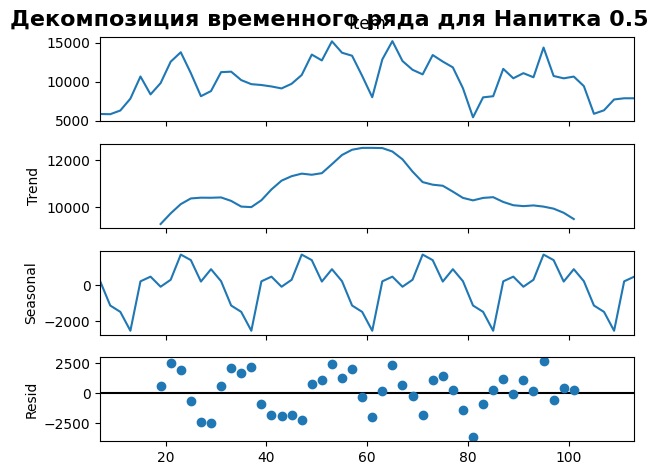

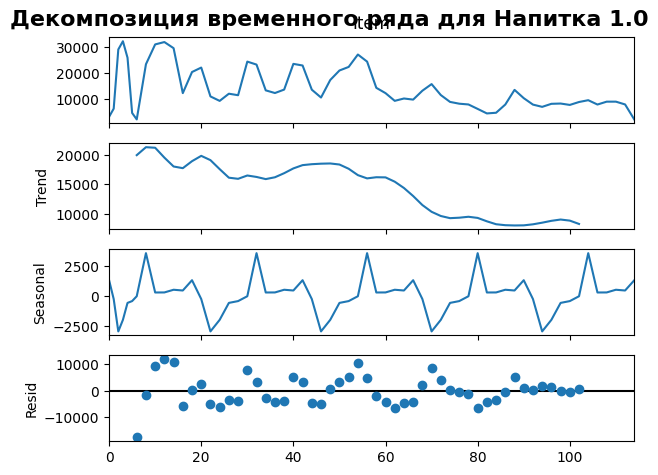

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Декомпозиция временного ряда для data_item_05_cleaned
decomposition_05 = seasonal_decompose(data_item_05_cleaned['Item'], model='additive', period=12) #используем аддитивную модель
decomposition_05.plot()
plt.suptitle('Декомпозиция временного ряда для Напитка 0.5', fontsize=16, fontweight='bold')
plt.show()

# Декомпозиция временного ряда для data_item_1_0_cleaned
decomposition_1_0 = seasonal_decompose(data_item_1_0_cleaned['Item'], model='additive', period=12)
decomposition_1_0.plot()
plt.suptitle('Декомпозиция временного ряда для Напитка 1.0', fontsize=16, fontweight='bold')
plt.show()

Интерпретация декомпозиции

**Напиток 0.5**
* Сезонность: Сезонная составляющая для напитка объемом 0.5 имеет регулярные колебания. Это может указывать на сезонный спрос, возможно, связанный с временем года или другими циклическими факторами, влияющими на продажи.
* Остаток (шум): Остаток для этого ряда показывает относительно небольшие отклонения, иногда выходящие за рамки ±2500. Наличие отрицательных значений указывает на периоды, когда фактические продажи были ниже ожидаемых (например, в июле 2021). Положительные значения в остатке, напротив, свидетельствуют о превышении продаж над ожидаемыми значениями.

**Напиток 1.0**
* Сезонность: Сезонная составляющая более выражена для напитка объемом 1.0, и регулярные пики могут указывать на влияние сезонных событий (например, летний рост спроса).
* Шум: наблюдаются отрицательные значения, например в марте и августе 2021 года. Эти периоды снижения продаж относительно прогноза на основе тренда и сезонности.

**Выводы и рекомендации**
* Для обоих напитков имеются сезонные колебания, это необходимо учитывать при планировании.
* Есть тренд на снижение продаж напитка 1.0 в конце периода. Необходимо пересмотреть условия/стратегию/активности связанные с этим магазином с целью повышения спроса/устранению возможных проблем влияющих на тренд.
* Наличие шума с отрицательными значегтяит (в обоих напитках) может указывать на влияние других факторов:конкуренция/условия. Рекомендуется провести дополнительный анализ, чтобы выявить причины снижения продаж в определенные периоды.довые изменения.


Проверка временные ряды на стационарность, т.е. имеют ли они постоянное среднее и дисперсию с течением времени.

In [41]:
#Импортируем необходимые библиотеки: для статистического анализа.
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [42]:
# Функция для проверки стационарности
def check_stationarity(series, series_name):
    result = adfuller(series)
    print(f"Тест Дики-Фуллера для {series_name}:")
    print(f"Статистика теста: {result[0]}")
    print(f"p-значение: {result[1]}")
    print(f"Число лагов: {result[2]}")
    print(f"Количество наблюдений: {result[3]}")
    print(f"Критические значения: {result[4]}")
    
    # Проверка на стационарность по p-значению
    if result[1] < 0.05:
        print(f"{series_name} является стационарным.")
    else:
        print(f"{series_name} не является стационарным.")

Общий вывод:
<br>**Item 0.5 Sales** — стационарен и может быть использован для моделирования временных рядов
<br>**Item 0.1 Sales** — нестационарен; для дальнейшего анализа можно дифференцирововать, чтобы его стабилизировать.

## 4. Подготовка данных к обучению модели и прогнозирование

Прогноз будет построен с помощью модели SARIMAX

В рамках первой модели будет SARIMAX, линейная модель которая также учтет сезонные колебаний и нелинейные завивисимости, а также внешние факторы (если необходиимо).

In [43]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [44]:
#Переименуем столбцы для будущей модели
item_05_forecast_data = data_item_05_cleaned.rename(columns={'Date': 'ds'}).rename(columns={'Item': 'y'}).copy()
item_10_forecast_data = data_item_1_0_cleaned.rename(columns={'Date': 'ds'}).rename(columns={'Item': 'y'}).copy()

In [45]:
# Выбираем необходимые столбцы для PackageSize 0.5
item_05_forecast_data = item_05_forecast_data[['ds', 'Price', 'DoD', 'Regular_Price', 'Promo_Price', 'y']].copy()
item_05_forecast_data['ds'] = pd.to_datetime(item_05_forecast_data['ds'])
item_05_forecast_data.info()

# Выбираем необходимые столбцы для PackageSize 1.0
item_10_forecast_data = item_10_forecast_data[['ds', 'Price', 'DoD', 'Regular_Price', 'Promo_Price', 'y']].copy()
item_10_forecast_data['ds'] = pd.to_datetime(item_10_forecast_data['ds'])
item_10_forecast_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54 entries, 7 to 113
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ds             54 non-null     datetime64[ns]
 1   Price          54 non-null     float64       
 2   DoD            54 non-null     float64       
 3   Regular_Price  53 non-null     float64       
 4   Promo_Price    54 non-null     float64       
 5   y              54 non-null     float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 3.0 KB
<class 'pandas.core.frame.DataFrame'>
Index: 61 entries, 0 to 114
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ds             61 non-null     datetime64[ns]
 1   Price          61 non-null     float64       
 2   DoD            61 non-null     float64       
 3   Regular_Price  61 non-null     float64       
 4   Promo_Price    61 non-null

In [46]:
# Сортируем данные по дате
item_05_forecast_data = item_05_forecast_data.sort_values('ds')
item_05_forecast_data.set_index('ds', inplace=True)

item_10_forecast_data = item_10_forecast_data.sort_values('ds')
item_10_forecast_data.set_index('ds', inplace=True)

In [47]:
# Разделяем данные по дате
focus_date_05 = '2021-09-27'
train_05 = item_05_forecast_data.loc[item_05_forecast_data.index < focus_date_05]
test_05 = item_05_forecast_data.loc[item_05_forecast_data.index >= focus_date_05]

print(f"Начальная дата в train_05 тренировочной выборке: {train_05.index.min()}")
print(f"Последняя дата в test_05 тестовой выборке: {test_05.index.max()}")
print()
# Разделяем данные по дате
focus_date_10 = '2021-09-01'
train_10 = item_10_forecast_data.loc[item_10_forecast_data.index < focus_date_10]
test_10 = item_10_forecast_data.loc[item_10_forecast_data.index >= focus_date_10]

print(f"Начальная дата в train_10 тренировочной выборке: {train_10.index.min()}")
print(f"Последняя дата в test_10 тестовой выборке: {test_10.index.max()}")

Начальная дата в train_05 тренировочной выборке: 2020-10-26 00:00:00
Последняя дата в test_05 тестовой выборке: 2021-11-01 00:00:00

Начальная дата в train_10 тренировочной выборке: 2020-09-07 00:00:00
Последняя дата в test_10 тестовой выборке: 2021-11-01 00:00:00


In [48]:
# Преобразуем данные в тренировочной и тестовой выборках
train_05 = train_05.copy()
test_05 = test_05.copy()
train_05.loc[:, 'log_y'] = np.log(train_05['y'] + 1) ########
test_05.loc[:, 'log_y'] = np.log(test_05['y'] + 1)

train_10 = train_10.copy()
test_10 = test_10.copy()
train_10.loc[:, 'log_y'] = np.log(train_10['y'] + 1)
test_10.loc[:, 'log_y'] = np.log(test_10['y'] + 1)

In [49]:
# Устанавливаем частоту еженедельных данных (каждую неделю, начиная с понедельника)

train_05.index = pd.to_datetime(train_05.index)
test_05.index = pd.to_datetime(test_05.index)

train_10.index = pd.to_datetime(train_10.index)
test_10.index = pd.to_datetime(test_10.index)

In [50]:
# Интерполяция пропущенных значений
train_05 = train_05.asfreq('W-MON').interpolate(method='linear')
test_05 = test_05.asfreq('W-MON').interpolate(method='linear')

train_10 = train_10.asfreq('W-MON').interpolate(method='linear')
test_10 = test_10.asfreq('W-MON').interpolate(method='linear')

## 5. Тренировочный прогноз на 2 недели для PackageSize 0.5

In [51]:
# Обучаем модель на логарифмированных данных train_05 тренировочной выборки
model_sarima_train_05 = SARIMAX(train_05['log_y'],order=(1, 1, 1),seasonal_order=(1, 1, 1, 12),enforce_stationarity=False,enforce_invertibility=False)
model_fit_train_05 = model_sarima_train_05.fit() # Подгоняем модель
##########order=(1, 1, 1)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.62231D-02    |proj g|=  3.29024D-01

At iterate    5    f=  2.48602D-02    |proj g|=  1.09004D-01

At iterate   10    f=  1.63484D-02    |proj g|=  1.20052D-02

At iterate   15    f=  1.42993D-02    |proj g|=  4.29923D-03

At iterate   20    f=  1.42908D-02    |proj g|=  1.68268D-04

At iterate   25    f=  1.42906D-02    |proj g|=  1.63940D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     30      1     0     0   

 This problem is unconstrained.


In [52]:
# Прогнозируем на 14 дней вперед, начиная с нужной даты
forecast_dates_train_05 = pd.date_range(start=focus_date_05, periods=14, freq='W-MON')

# Прогнозируем данные на 14 дней вперед на основе модели
forecast_train_05 = model_fit_train_05.get_forecast(steps=14)

In [53]:
# Получаем прогнозированные значения
forecast_values_train_05 = forecast_train_05.predicted_mean

# Если необходимо, можно вернуть данные в оригинальный масштаб (без логарифмирования):
forecast_values_original_train_05 = np.exp(forecast_values_train_05) - 1  # Обратное преобразование

# Отображаем прогноз
print(forecast_values_original_train_05.tail(5))

2021-11-29    10994.098155
2021-12-06    11301.658569
2021-12-13    11711.598111
2021-12-20     9802.923153
2021-12-27     8076.308128
Freq: W-MON, Name: predicted_mean, dtype: float64


In [54]:
# Создание DataFrame
forecast_df_train_05 = pd.DataFrame({'forecast': forecast_values_original_train_05}, index=forecast_dates_train_05)

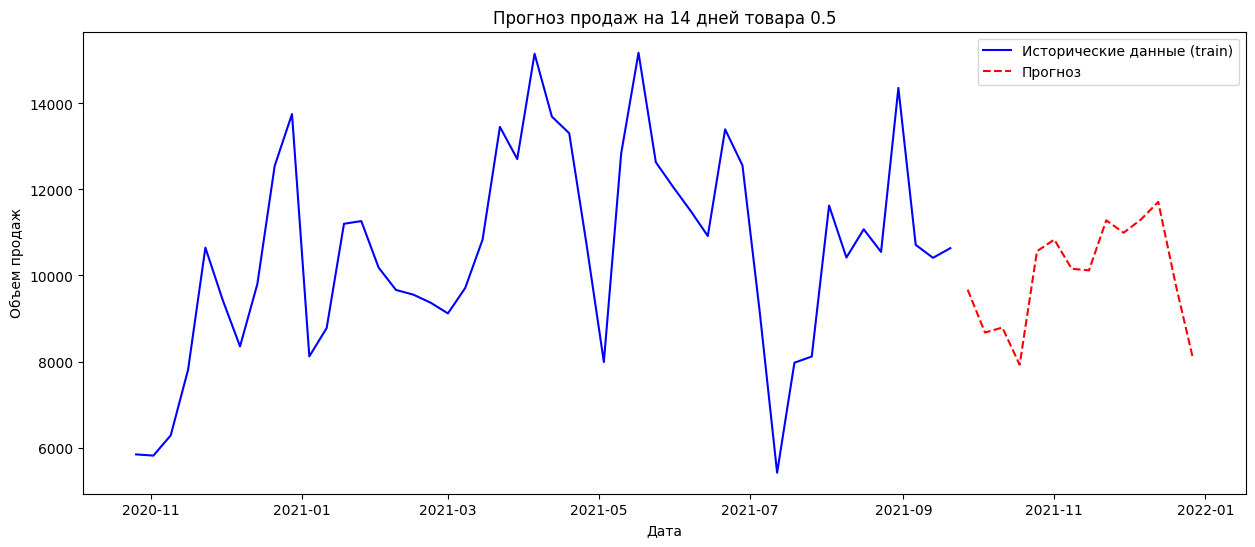

In [55]:
plt.figure(figsize=(15, 6))

# Исторические данные (train), отображаем как линию и точки
plt.plot(train_05.index, np.exp(train_05['log_y']) - 1, label='Исторические данные (train)', color='blue')
# Прогноз, отображаем как линию
plt.plot(forecast_values_original_train_05.index, forecast_df_train_05['forecast'], label='Прогноз', color='red', linestyle='--')

plt.title('Прогноз продаж на 14 дней товара 0.5')
plt.xlabel('Дата')
plt.ylabel('Объем продаж')
plt.legend()
plt.show()

In [56]:
forecast_values_original_train_05 = forecast_values_original_train_05[:len(test_05)]
mae_05 = mean_absolute_error(test_05['y'], forecast_values_original_train_05)
rmse_05 = np.sqrt(mean_squared_error(test_05['y'], forecast_values_original_train_05))

print(f'Mean Absolute Error (MAE): {mae_05}')
print(f'Root Mean Squared Error (RMSE): {rmse_05}')

Mean Absolute Error (MAE): 1909.930961453907
Root Mean Squared Error (RMSE): 2250.0738236451552


In [57]:
# Вывод первых 5 строк
print(forecast_df_train_05.head(5))

                forecast
2021-09-27   9669.002777
2021-10-04   8673.572117
2021-10-11   8789.307227
2021-10-18   7925.968370
2021-10-25  10564.449869


## 6. Тренировочный прогноз на 2 недели для PackageSize 1.0

In [58]:
# Обучаем модель на логарифмированных данных train тренировочной выборки
model_sarima_train = SARIMAX(train_10['log_y'],order=(1, 1, 1),seasonal_order=(1, 1, 1, 12),enforce_stationarity=False,enforce_invertibility=False)

# Подгоняем модель
model_fit_train = model_sarima_train.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57395D+01    |proj g|=  6.59857D-01
  ys=-2.605E+00  -gs= 4.231E-01 BFGS update SKIPPED


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      4     67      2     1     0   1.088D+05   9.221D+00
  F =   9.2213798365541475     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


In [59]:
# Прогнозируем на 14 дней вперед, начиная с нужной даты
forecast_dates_train = pd.date_range(start=focus_date_10, periods=14, freq='W-MON')

# Прогнозируем данные на 14 дней вперед на основе модели
forecast_train = model_fit_train.get_forecast(steps=14)

# Получаем прогнозированные значения и преобразуем их обратно (для тестирования и использования в реальных данных)
forecast_values_train = forecast_train.predicted_mean
forecast_values_original_train = np.exp(forecast_values_train) - 1  # Обратное преобразование

print(forecast_values_original_train.head(5))

2021-09-06    8209.546628
2021-09-13    7730.235652
2021-09-20    8452.039467
2021-09-27    7147.852667
2021-10-04    4566.804428
Freq: W-MON, Name: predicted_mean, dtype: float64


In [60]:
# Добавляем прогнозируемые значения в DataFrame
forecast_df_10_train = pd.DataFrame({'forecast': forecast_values_original_train}, index=forecast_dates_train)

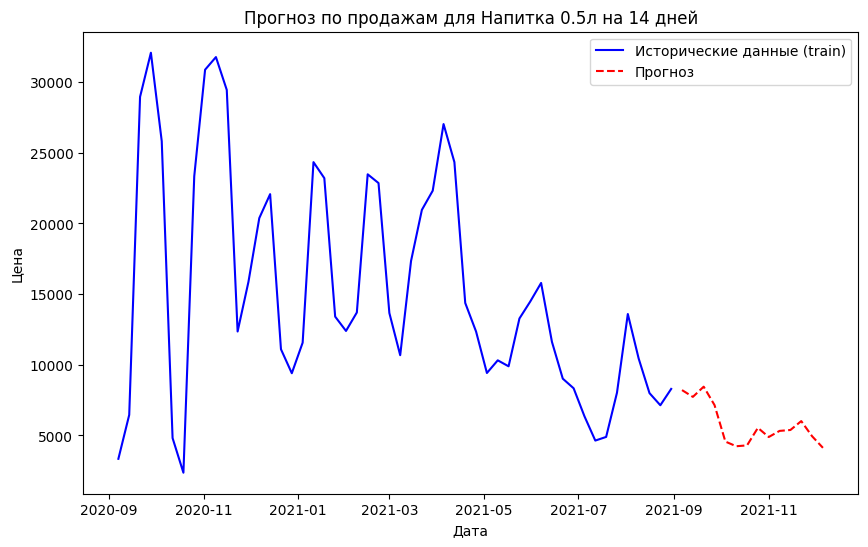

In [61]:
plt.figure(figsize=(10, 6))

# Исторические данные (train), отображаем как линию и точки
plt.plot(train_10.index, np.exp(train_10['log_y']) - 1, label='Исторические данные (train)', color='blue')

# Прогноз, отображаем как линию
plt.plot(forecast_df_10_train.index, forecast_df_10_train['forecast'], label='Прогноз', color='red', linestyle='--')

# Настройки графика
plt.title('Прогноз по продажам для Напитка 0.5л на 14 дней')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()

In [62]:
forecast_values_original_train = forecast_values_original_train[:len(test_10)]

mae = mean_absolute_error(test_10['y'], forecast_values_original_train)
rmse = np.sqrt(mean_squared_error(test_10['y'], forecast_values_original_train))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 2400.645092958479
Root Mean Squared Error (RMSE): 2952.907544828133


## 7. Основной прогноз на 2 недели для PackageSize 0.5л.

Логарифмируем(стабилизируем) Item 0.1 Sales

In [63]:
item_05_forecast_data['log_y'] = np.log(item_05_forecast_data['y'] + 1)  # Применение логарифма к продажам с корректировкой на 0

In [64]:
item_05_forecast_data.tail()

,Price,DoD,Regular_Price,Promo_Price,y,log_y
ds,,,,,,
2021-10-04,1011.15,0.2130,1191.90,1010.40,5864.0,8.676758
2021-10-11,891.60,0.2305,1295.55,891.30,6313.0,8.750525
2021-10-18,875.85,0.2480,1105.05,875.85,7700.0,8.949105
2021-10-25,870.30,0.2960,1157.25,870.15,7854.0,8.968906
2021-11-01,871.80,0.2580,1106.10,868.50,7854.0,8.968906


In [65]:
# Устанавливаем частоту еженедельных данных (каждую неделю, начиная с понедельника)
item_05_forecast_data.index = pd.to_datetime(item_05_forecast_data.index)  # Если индекс не в формате datetime
item_05_forecast_data = item_05_forecast_data.asfreq('W-MON').interpolate(method='linear')

In [66]:
# Задаем последнюю дату из исторических данных
last_date_05 = item_05_forecast_data.index[-1]
print(last_date_05)

2021-11-01 00:00:00


In [67]:
# Обучаем модель на преобразованных данных
model_sarima_05 = SARIMAX(item_05_forecast_data['log_y'],order=(1, 1, 1),seasonal_order=(1, 1, 1, 12),enforce_stationarity=False,enforce_invertibility=False)
model_fit_05 = model_sarima_05.fit()

#прогнозируем на 14 дней вперед
forecast_dates_05 = pd.date_range(start='2021-11-04', periods=14, freq='W-MON')

#Проверяем прогнозируем даты и частотность
print(forecast_dates_05)
print()
print(item_05_forecast_data.index.freq)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13804D-01    |proj g|=  2.73871D-01

At iterate    5    f= -2.93981D-03    |proj g|=  3.44204D-02

At iterate   10    f= -1.20859D-02    |proj g|=  2.33117D-02

At iterate   15    f= -1.31552D-02    |proj g|=  2.95674D-01

At iterate   20    f= -1.31642D-02    |proj g|=  8.89739D-03


 This problem is unconstrained.



At iterate   25    f= -1.31793D-02    |proj g|=  3.24411D-01

At iterate   30    f= -1.32166D-02    |proj g|=  9.03979D-03

At iterate   35    f= -1.32168D-02    |proj g|=  1.57558D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     61      1     0     0   1.576D-04  -1.322D-02
  F =  -1.3216763224309504E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
DatetimeIndex(['2021-11-08', '2021-11-15', '2021-11-22', '2021-11-29',
               '2021-12-06', '2021-12-13', '2021-12-20', '2021-12-27',
               '2022-01-03', '2022-01-10', '2022-01-17', '2022-01-24',
               '2022-01-

In [68]:
# Прогнозируем в логарифмированном масштабе
y_pred_log_05 = model_fit_05.forecast(steps=14)

# Преобразуем обратно в исходный масштаб (экспоненцируем результат)
# прогнозы также будут логарифмированными, поэтому для интерпретации результата в исходных единицах данных нужно экспоненцировать прогноз.
y_pred_05 = np.exp(y_pred_log_05) - 1

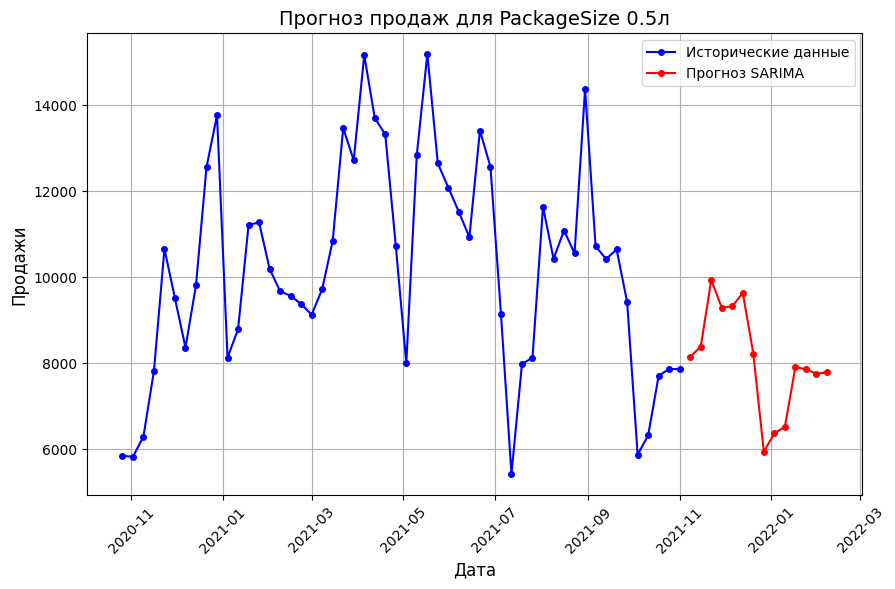

In [69]:
plt.figure(figsize=(10, 6))

# Исторические данные (синие точки)
plt.plot(item_05_forecast_data.index, item_05_forecast_data['y'], label='Исторические данные', color='blue', marker='o', linestyle='-', markersize=4)

# Прогноз SARIMA (красные точки и линия)
plt.plot(forecast_dates_05, y_pred_05, label='Прогноз SARIMA', color='red', linestyle='-', marker='o', markersize=4)

plt.title('Прогноз продаж для PackageSize 0.5л', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Продажи', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [70]:
forecast_dates_05

DatetimeIndex(['2021-11-08', '2021-11-15', '2021-11-22', '2021-11-29',
               '2021-12-06', '2021-12-13', '2021-12-20', '2021-12-27',
               '2022-01-03', '2022-01-10', '2022-01-17', '2022-01-24',
               '2022-01-31', '2022-02-07'],
              dtype='datetime64[ns]', freq='W-MON')

In [71]:
# Преобразуем прогнозируемые даты в Series
forecast_series_05 = pd.Series(y_pred_05, index=forecast_dates_05)
# Объединяем их в один DataFrame
forecast_df_05 = pd.DataFrame({'Forecast': forecast_series_05})

In [72]:
forecast_df_05.tail(5)

,Forecast
2022-01-10,6508.000071
2022-01-17,7898.461144
2022-01-24,7852.440050
2022-01-31,7745.854346
2022-02-07,7775.876016


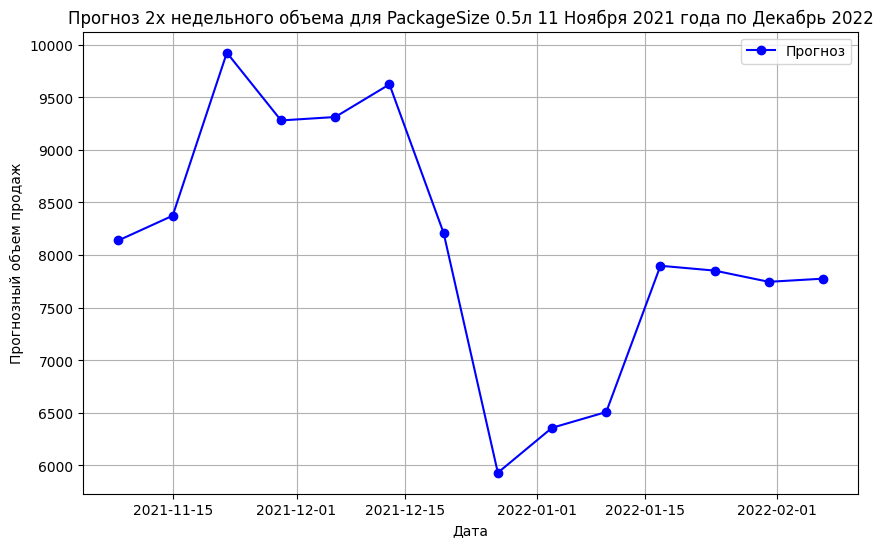

In [73]:
plt.figure(figsize=(10, 6))

# График только прогноза (по понедельникам)
plt.plot(forecast_df_05.index, forecast_df_05['Forecast'], label='Прогноз', color='blue', marker='o')

plt.title('Прогноз 2х недельного объема для PackageSize 0.5л 11 Ноября 2021 года по Декабрь 2022')
plt.xlabel('Дата')
plt.ylabel('Прогнозный объем продаж')
plt.legend()
plt.grid(True)
plt.show()

## 8. Основной прогноз на 2 недели для PackageSize 1.0


In [74]:
# Применяем логарифм для для стабилизации дисперсии и преобразования данных в более «нормальный» вид, помогает уменьшить влияние резких скачков.
item_10_forecast_data['log_y'] = np.log(item_10_forecast_data['y'] + 1)  # +1 чтобы избежать логарифма от 0
item_10_forecast_data.index = pd.to_datetime(item_10_forecast_data.index)  # Если индекс не в формате datetime
# Интерполяция пропущенных значений
item_10_forecast_data = item_10_forecast_data.asfreq('W-MON').interpolate(method='linear') # Интерполяция пропущенных значений

In [75]:
item_10_forecast_data.tail()

,Price,DoD,Regular_Price,Promo_Price,y,log_y
ds,,,,,,
2021-10-04,1339.35,0.15400,1573.950000,1150.15,8022.000000,8.990068
2021-10-11,1338.00,0.31100,1672.800000,1144.55,9110.000000,9.117238
2021-10-18,1138.95,0.25684,1442.532158,1138.95,9115.000000,9.117786
2021-10-25,1132.05,0.35700,1628.400000,1131.60,8053.000000,8.993924
2021-11-01,1135.35,0.29200,1563.450000,1129.50,2326.000075,7.752335


In [76]:
# Задаем последнюю дату из исторических данных
last_date_10 = item_10_forecast_data.index[-1]
print(last_date_10)

2021-11-01 00:00:00


In [77]:
# Обучаем модель на преобразованных данных

model_sarima = SARIMAX(item_10_forecast_data['log_y'],order=(1, 1, 1),seasonal_order=(1, 1, 1, 12),enforce_stationarity=False,enforce_invertibility=False)
model_fit = model_sarima.fit()

#прогнозируем на 14 дней вперед
forecast_dates_10 = pd.date_range(start='2021-11-08', periods=14, freq='W-MON')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.79958D+01    |proj g|=  8.19609D-01
  ys=-8.788E+01  -gs= 5.539E-01 BFGS update SKIPPED
  ys=-1.863E+01  -gs= 5.416E-01 BFGS update SKIPPED


 This problem is unconstrained.



At iterate    5    f=  1.14073D+01    |proj g|=  8.03801D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      5     45      3     2     0   8.038D-06   1.141D+01
  F =   11.407342557051313     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [78]:
print(forecast_dates_10)
print(item_10_forecast_data.index.freq)

DatetimeIndex(['2021-11-08', '2021-11-15', '2021-11-22', '2021-11-29',
               '2021-12-06', '2021-12-13', '2021-12-20', '2021-12-27',
               '2022-01-03', '2022-01-10', '2022-01-17', '2022-01-24',
               '2022-01-31', '2022-02-07'],
              dtype='datetime64[ns]', freq='W-MON')
<Week: weekday=0>


In [79]:
# Прогнозируем в логарифмированном масштабе
y_pred_log_10 = model_fit.forecast(steps=14)

# Преобразуем обратно в исходный масштаб (экспоненцируем результат)
y_pred_10 = np.exp(y_pred_log_10) - 1

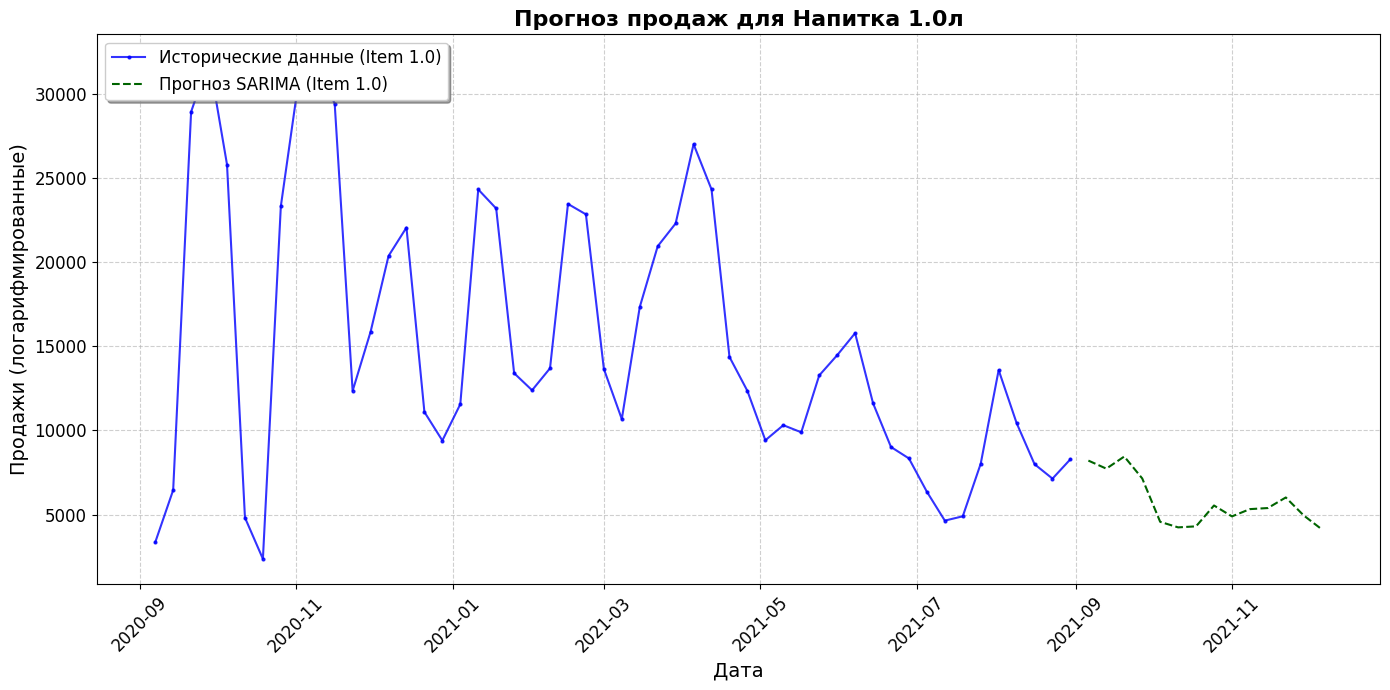

In [80]:
plt.figure(figsize=(14, 7))

# Исторические данные для Item 1.0
plt.plot(train_10.index, 
         np.exp(train_10['log_y']) - 1, 
         label='Исторические данные (Item 1.0)', 
         color='blue', 
         linestyle='-', 
         alpha=0.8, marker='o', 
         markersize=2)

# Прогноз SARIMA для Item 1.0
plt.plot(forecast_df_10_train.index, 
         forecast_df_10_train['forecast'], 
         label='Прогноз SARIMA (Item 1.0)', 
         color='darkgreen', linestyle='--', 
         linewidth=1.5)

plt.title('Прогноз продаж для Напитка 1.0л', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Продажи (логарифмированные)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left', fontsize=12, frameon=True, shadow=True, fancybox=True)
plt.tight_layout()
plt.show()


In [81]:
forecast_dates_10

DatetimeIndex(['2021-11-08', '2021-11-15', '2021-11-22', '2021-11-29',
               '2021-12-06', '2021-12-13', '2021-12-20', '2021-12-27',
               '2022-01-03', '2022-01-10', '2022-01-17', '2022-01-24',
               '2022-01-31', '2022-02-07'],
              dtype='datetime64[ns]', freq='W-MON')

In [92]:
forecast_series_10 = pd.Series(y_pred_10, index=forecast_dates_10) #Преобразуем прогнозируемые даты в Series
forecast_df_10 = pd.DataFrame({'Forecast': forecast_series_10}) # Объединяем в DataFrame

## 7. Визуализация результатов основного прогноза

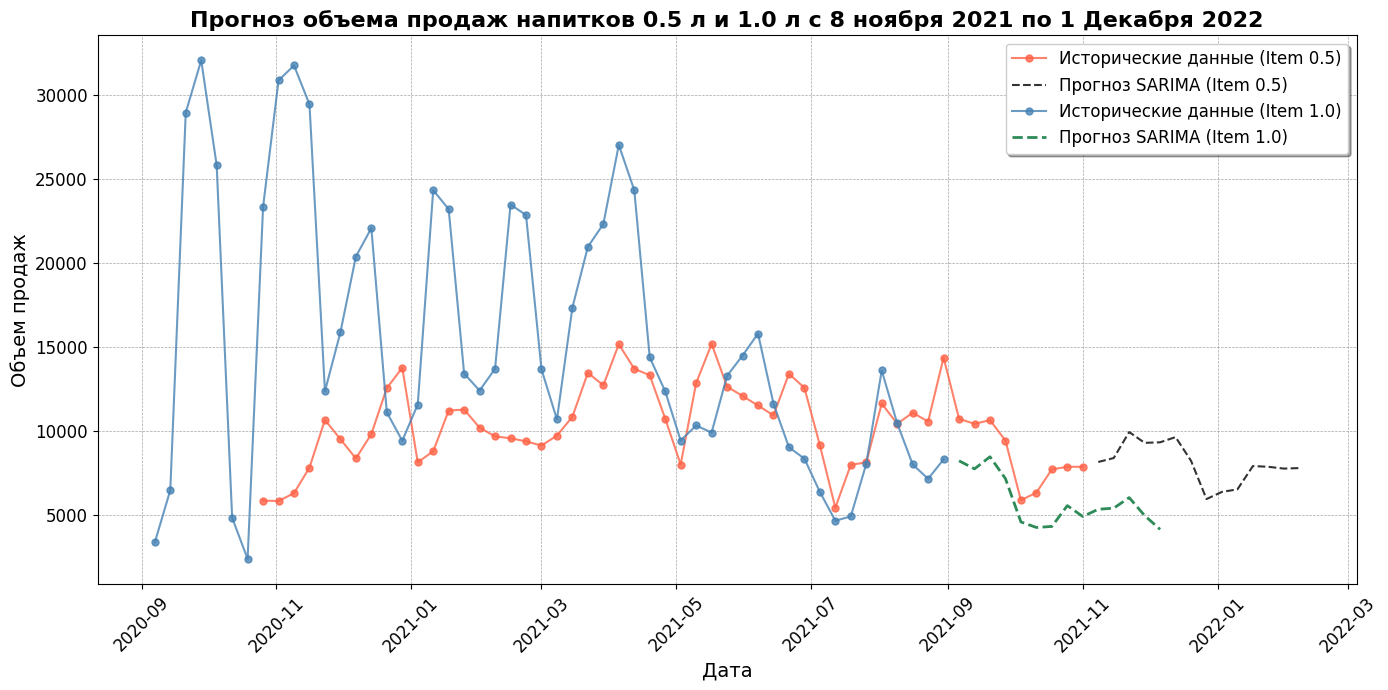

In [83]:
plt.figure(figsize=(14, 7))

# original data Item 0.5
plt.plot(item_05_forecast_data.index, 
         item_05_forecast_data['y'], 
         label='original data Item 0.5', 
         color='#FF6347',  # tomato color
         marker='o', 
         alpha=0.8, 
         linestyle='-', 
         markersize=5) 

# forecast for Item 0.5
plt.plot(forecast_dates_05, 
         y_pred_05, 
         label='forecast Item 0.5', 
         color='#333333', 
         linestyle='--',
         markersize=5)

# original data Item 1.0
plt.plot(train_10.index, 
         np.exp(train_10['log_y']) - 1, 
         label='original data Item 1.0', 
         color='#4682B4', 
         linestyle='-', 
         alpha=0.8, 
         marker='o', 
         markersize=5)

# forecast for Item 1.0
plt.plot(forecast_df_10_train.index, 
         forecast_df_10_train['forecast'], 
         label='forecast Item 1.0', 
         color='#2E8B57', 
         linestyle='--', 
         linewidth=2)

# Setting the title and labels for the axes
plt.title('Sales Volume Forecast for 0.5L and 1.0L Drinks: November 8, 2021, to December 1, 2022', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales Volune', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc='upper right', fontsize=12, frameon=True, shadow=True, fancybox=True)
plt.tight_layout()
plt.show()


In [91]:
# Based on the forecast for both drinks (0.5L and 1.0L), some volatility can be expected, but a return to the high peaks observed earlier in September and October is unlikely.

The historical data for both volumes (0.5L and 1.0L) shows regular fluctuations. There is a noticeable decline in sales volumes in the recent months, with a decrease in amplitude as well.

<br>**For 0.5L**: A significant decline is observed towards the beginning of the forecast period (starting from November 2021), possibly due to a decrease in demand during the colder season.
<br>**For 1.0L**: A slight decline is also noted at the start of the forecast period, but there is a potential increase in sales by spring 2022 (possibly due to a seasonal demand boost?).

In [85]:
forecast_df_05

,Forecast
2021-11-08,8139.775837
2021-11-15,8374.344326
2021-11-22,9923.911470
2021-11-29,9280.195074
2021-12-06,9312.794967
2021-12-13,9623.013702
2021-12-20,8209.125337
2021-12-27,5930.879584
2022-01-03,6358.006806
2022-01-10,6508.000071


In [86]:
forecast_df_10

,Forecast
2021-11-08,1916.443746
2021-11-15,1781.157401
2021-11-22,1975.227236
2021-11-29,1706.478125
2021-12-06,1457.914793
2021-12-13,1502.104121
2021-12-20,1368.367028
2021-12-27,1066.774939
2022-01-03,1169.506461
2022-01-10,1485.596069


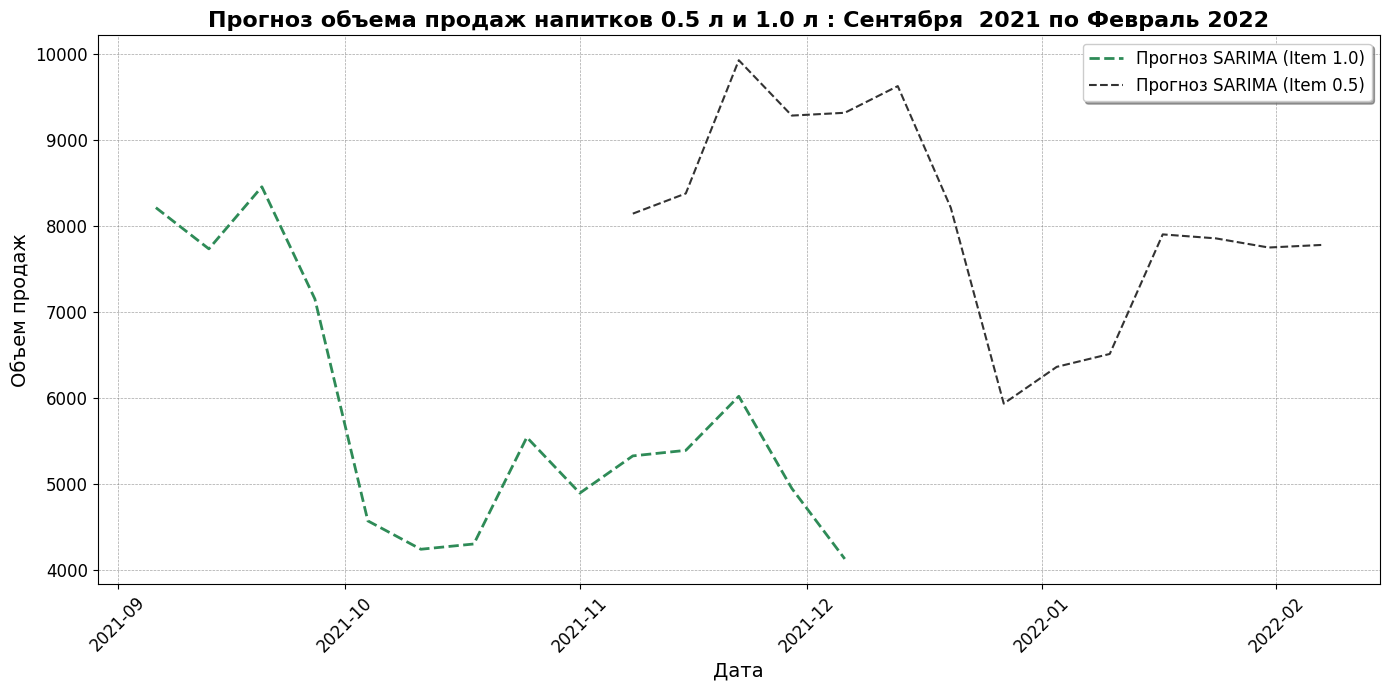

In [87]:
plt.figure(figsize=(14, 7))


# Прогноз SARIMA для Item 1.0 (темно-зеленый)
plt.plot(forecast_df_10_train.index, 
         forecast_df_10_train['forecast'], 
         label='forecast Item 1.0', 
         color='#2E8B57', 
         linestyle='--', 
         linewidth=2)

# Прогноз SARIMA для Item 0.5 (черный)
plt.plot(forecast_dates_05, 
         y_pred_05, 
         label='forecast Item 0.5', 
         color='#333333', 
         linestyle='--',
         markersize=5)

# Настройка заголовка и подписей осей
plt.title('Sales Volume Forecast for Drinks 0.5L and 1.0L: September 2021 to February 2022', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales Volume', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc='upper right', fontsize=12, frameon=True, shadow=True, fancybox=True)
plt.tight_layout()
plt.show()